In [1]:
import torch
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
from typing import Any
from typing import Dict
from typing import List
from typing import Optional
from typing import Tuple
import pandas as pd

2023-07-25 11:41:22.137682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
msa = pd.read_csv('SH3_Full_Dataset_8_9_22.csv')
msa['Type'].unique()
naturals_msa = msa[msa['Type']=='Naturals']
seqs = np.asarray([list(seq) for seq in naturals_msa['Sequences']])
norm_re = np.asarray([re for re in naturals_msa['Norm_RE']])

In [3]:
default_aa_keys='-GALMFWKQESPVICYHRNDT'
def fasta_to_df(fasta_file, aa_keys = default_aa_keys):
    """
    creates one hot encoding of a fasta file using biopython's alignio.read process. 
    fasta_file : filepath leading to msa file in fasta format at hand
    """
    column_names = []
    column_names.extend(aa_keys)
    msa=AlignIO.read(fasta_file, "fasta")
    num_columns = len(msa[0].seq)
    column_names = column_names*num_columns
    column_names.append('sequence')
    column_names.append('id')
    init = np.zeros((len(msa), len(column_names)))
    df = pd.DataFrame(init, columns = column_names)
    df.sequence = df.sequence.astype(str)
    df.id=df.id.astype(str)
    
    for row_num, alignment in tqdm(enumerate(msa)):
        sequence = str(alignment.seq)
        for index, char in enumerate(sequence):
            place = aa_keys.find(char)
            df.iloc[row_num, index*len(aa_keys) + place] = 1
        
        df.iloc[row_num,-2]=str(alignment.seq)
        df.iloc[row_num,-1]=str(alignment.id)
    
    return df

In [4]:
def create_frequency_matrix(df, aa_keys = default_aa_keys):
    """takes one hot encoded msa and returns the frequency of each amino acid at each site
    df : pandas dataframe whose columns are the one hot encoding of an msa
    """
    num_columns=len(df['sequence'][0])
    
    frequency_matrix = np.zeros( (len(aa_keys) , num_columns) )
    print('calcing sum')
    freq=df.sum()
    print('sum calced')
    
    num_entries=len(df)
    len_aa_keys = len(aa_keys)
    
    for i in tqdm(range(len(aa_keys))):
        for j in range(num_columns):
            frequency_matrix[i, j] = freq[ i + len_aa_keys * j] / num_entries
    
    return frequency_matrix

In [5]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
vae_alignment = []
phenotypes = []

vae_data = msa[msa['Type']=='VAE'].reset_index()

for r in range(len(vae_data)):
    alignment = vae_data.loc[r]
    if len(alignment['Sequences'])==62:
        record = SeqRecord(seq = Seq(alignment['Sequences']), id = alignment['Header'])
    
    vae_alignment.append(record)
    phenotypes.append(alignment['Norm_RE'])

vae_alignment = AlignIO.MultipleSeqAlignment(vae_alignment)

AlignIO.write(vae_alignment, 'vae_alignment.fasta', 'fasta')

vae_df = fasta_to_df('vae_alignment.fasta')

freq_matrix = create_frequency_matrix(vae_df)

trim_positions = []

for i in range(freq_matrix.shape[1]):
    if 1 in freq_matrix[:,i]:
        trim_positions.append(i)

print(trim_positions)


vae_alignment_trimmed = []


for alignment in vae_alignment:
    new_seq = ''
    for i in range(62):
        if i not in trim_positions:
            new_seq+=alignment.seq[i]
    re_alignment = SeqRecord(seq=Seq(new_seq), id = alignment.id)
    vae_alignment_trimmed.append(re_alignment)

vae_alignment_trimmed = AlignIO.MultipleSeqAlignment(vae_alignment_trimmed)

AlignIO.write(vae_alignment_trimmed, 'vae_alignment_trimmed.fasta', 'fasta')

test_seqs = np.asarray([list(str(alignment.seq)) for alignment in vae_alignment_trimmed])

phenotypes = np.asarray(phenotypes)

11608it [02:57, 65.49it/s]


calcing sum
sum calced


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 6608.18it/s]

[16, 17, 44]


In [6]:
AMINO_ACIDS = "ARNDCQEGHILKMFPSTWYV-"
IDX_TO_AA = list(AMINO_ACIDS)
AA_TO_IDX = {aa: i for i, aa in enumerate(IDX_TO_AA)}

In [7]:
CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        data: Optional[np.ndarray] = None,
        top_model = False,
        regression_target = None,
        batch_size: int = 100,
        n_steps_per_epoch: int = 50,
        shuffle: bool = True
    ):

        self.data = data
        self.batch_size = batch_size
        self.n_steps_per_epoch = n_steps_per_epoch
        self.shuffle = shuffle
        self.top_model = top_model
        
        if self.shuffle:
            self.step_batch_idx = np.random.choice(len(self.data), size=(self.n_steps_per_epoch, self.batch_size))
        else:
            self.step_batch_idx = np.arange(len(self.data)).reshape((1, -1))
        
        if self.top_model:
            self.regression_target = regression_target

            
    def __len__(self):
        return self.n_steps_per_epoch
        
    def __getitem__(self, i_batch):
        output = self.__data_generation(i_batch)
        X, y = output.query, output.target_y
            
        return X, y
        
    def on_epoch_end(self):
        if self.shuffle:

            self.step_batch_idx = np.random.choice(len(self.data), size=(self.n_steps_per_epoch, self.batch_size))
        else:
            self.step_batch_idx = np.arange(len(self.data)).reshape((1, -1))
        
    def __data_generation(self, i_batch):
        batch_idx = self.step_batch_idx[i_batch]

        
        num_context_points = tf.random.uniform(shape=[], minval=3, maxval=int(0.9*self.data.shape[1]), dtype=tf.int32)
        num_target_points = self.data.shape[1] - num_context_points

        context_X = np.zeros((self.batch_size, num_context_points, 1), dtype = np.float32)
        context_Y = np.zeros((self.batch_size, num_context_points, len(AA_TO_IDX)), dtype = np.float32)

        target_X = np.zeros((self.batch_size, num_target_points, 1), dtype=np.float32)
        target_Y = np.zeros((self.batch_size, num_target_points, len(AA_TO_IDX)), dtype = np.float32)
        
        for i_data, idx in enumerate(batch_idx):
            
            shuffled_indices = tf.random.shuffle(tf.range(self.data.shape[1]))
            context_X[i_data,:,0] = shuffled_indices[:num_context_points]
            target_X[i_data, :,0] = shuffled_indices[num_context_points:]

            for y_index, context_index in enumerate(context_X[i_data,:]):
                aa = self.data[batch_idx[0], int(context_index)]
                context_Y[i_data, y_index, AA_TO_IDX[aa]] = 1

                    
            for y_index, target_index in enumerate(target_X[i_data,:]):
                aa = self.data[batch_idx[0], int(target_index)]
                target_Y[i_data, y_index, AA_TO_IDX[aa]] = 1
            
        query = ((context_X, context_Y), target_X)

        return CNPRegressionDescription(
            query = query,
            target_y = target_Y,
            num_total_points = self.data.shape[1]-num_context_points,
            num_context_points = num_context_points)
            

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, _, _ = train_test_split(seqs, norm_re)

In [10]:
print(X_train.shape)
print(X_test.shape)

(5898, 59)
(1967, 59)


In [11]:
dg_npr = DataGenerator(
    data = X_train
)

dg_npr_val = DataGenerator(
    data = X_test,
)



dg_npr_test = DataGenerator(
    data = test_seqs
)

In [12]:
class DeterministicEncoderProtein(tf.keras.Model):
    def __init__(self, output_sizes, **kwargs):
        super(DeterministicEncoderProtein, self).__init__(**kwargs)
        self._output_sizes = output_sizes
        self.mlp = tf.keras.models.Sequential()
        for i, size in enumerate(output_sizes[:-1]):
            self.mlp.add(tf.keras.layers.Dense(size, activation='relu'))
        self.mlp.add(tf.keras.layers.Dense(output_sizes[-1]))
        

    def call(self, context_x, context_y, num_context_points):
        encoder_input = tf.concat([context_x, context_y], axis = -1)

        batch_size, _, filter_size = encoder_input.shape.as_list()
        hidden = tf.reshape(encoder_input, (batch_size * num_context_points, -1))
        hidden.set_shape((None, filter_size))
        hidden = self.mlp(hidden)

        hidden = tf.reshape(hidden, (batch_size, num_context_points, self._output_sizes[-1]))
        representation = tf.reduce_mean(hidden, axis=1)

        return representation

In [13]:
class DeterministicDecoderProtein(tf.keras.Model):
    def __init__(self, output_sizes, **kwargs):
        super(DeterministicDecoderProtein, self).__init__(**kwargs)
        self._output_sizes = output_sizes
        self.mlp = tf.keras.models.Sequential()
        for i, size in enumerate(output_sizes[:-1]):
            self.mlp.add(tf.keras.layers.Dense(size, activation='relu'))
        self.mlp.add(tf.keras.layers.Dense(output_sizes[-1]))
        self.mlp.add(tf.keras.layers.Softmax())

    def call(self, representation, target_x, num_total_points):
        # Concatenate the representation and the target_x
        representation = tf.tile(
            tf.expand_dims(representation, axis=1), [1, num_total_points, 1])
        input = tf.concat([representation, target_x], axis=-1)
        
        # Get the shapes of the input and reshape to parallelise across observations
        batch_size, _, filter_size = input.shape.as_list()
        hidden = tf.reshape(input, (batch_size * num_total_points, -1))
        hidden.set_shape((None, filter_size))

        hidden = self.mlp(hidden)

        hidden = tf.reshape(hidden, (batch_size, num_total_points, -1))

        return hidden

In [14]:
encoder = DeterministicEncoderProtein([128,128,128,128])

In [15]:
decoder = DeterministicDecoderProtein([128,128,128,21])

In [16]:
test = dg_npr[0]
X = test[0]
y = test[1]

context_X = X[0][0]
context_y = X[0][1]
target_X = X[1]
target_y = y
num_context_points = context_X.shape[1]
num_target_points = target_y.shape[1]

In [17]:
print(context_X.shape)
print(context_y.shape)
print(target_X.shape)
print(target_y.shape)

(100, 34, 1)
(100, 34, 21)
(100, 25, 1)
(100, 25, 21)


In [18]:
rep = encoder(context_X, context_y, num_context_points)

In [19]:
decoded = decoder(rep, target_X, num_target_points)

In [40]:
def cross_entropy_loss(y_true, y_pred):
    eps=1e-6
    mean_cross_ent_per_pos = -tf.reduce_mean(
        tf.reduce_sum(
            y_true * tf.math.log(y_pred+eps) + (1-y_true) * tf.math.log(1-y_pred+eps)
            , axis=-1
        )
    )
    
    return mean_cross_ent_per_pos

In [41]:
class DeterministicModel(tf.keras.Model):
    """The CNP model."""

    def __init__(self, encoder_output_sizes, decoder_output_sizes, **kwargs):
        """Initialises the model.
    
        Args:
          encoder_output_sizes: An iterable containing the sizes of hidden layers of
              the encoder. The last one is the size of the representation r.
          decoder_output_sizes: An iterable containing the sizes of hidden layers of
              the decoder. The last element should correspond to the dimension of
              the y * 2 (it encodes both mean and variance concatenated)
        """
        super(DeterministicModel, self).__init__(**kwargs)
        self.encoder = DeterministicEncoderProtein(encoder_output_sizes)
        self.decoder = DeterministicDecoderProtein(decoder_output_sizes)
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.val_total_loss_tracker = tf.keras.metrics.Mean(name='val_total_loss')
        
        

    def call(self, data):
        query, target_y = data
        num_total_points = target_y.shape[1]
        num_context_points = query[0][0].shape[1]

        representation = self.encoder(query[0][0], query[0][1], num_context_points)
        decoded_output = self.decoder(representation, query[1], num_total_points)

        return decoded_output


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
        ]
    def train_step(self, data):
        with tf.GradientTape() as tape:
            query, target_y = data
            num_total_points = target_y.shape[1]
            num_context_points = query[0][0].shape[1]
            representation = self.encoder(query[0][0], query[0][1], num_context_points)
            decoded_output = self.decoder(representation, query[1], num_total_points)


            loss = cross_entropy_loss(target_y, decoded_output)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss)

        return {'total_loss':self.total_loss_tracker.result()}

    def test_step(self, data):
        query, target_y = data
        num_total_points = target_y.shape[1]
        num_context_points = query[0][0].shape[1]
        
        representation = self.encoder(query[0][0], query[0][1], num_context_points)
        decoded_output = self.decoder(representation, query[1], num_total_points)



        loss = cross_entropy_loss(target_y, decoded_output)
        self.val_total_loss_tracker.update_state(loss)

        return {
            'total_loss' : self.val_total_loss_tracker.result()
        }

In [42]:
npr_model = DeterministicModel([128,128,128,128],[128,128,128,21])

In [43]:
npr_model(dg_npr[0])

<tf.Tensor: shape=(100, 49, 21), dtype=float32, numpy=
array([[[0.01898238, 0.05160854, 0.03821808, ..., 0.0211832 ,
         0.04602319, 0.04511344],
        [0.00452504, 0.05400533, 0.14103612, ..., 0.00753824,
         0.01590016, 0.02698615],
        [0.00606278, 0.05397311, 0.12762131, ..., 0.01007859,
         0.02078674, 0.03114326],
        ...,
        [0.00649967, 0.0539226 , 0.12371557, ..., 0.01071977,
         0.02194987, 0.03204651],
        [0.00078818, 0.04376023, 0.19084409, ..., 0.00134861,
         0.00292426, 0.0097687 ],
        [0.00280295, 0.05270721, 0.15743677, ..., 0.00476227,
         0.01014564, 0.02087888]],

       [[0.00653888, 0.05431509, 0.12363863, ..., 0.01076283,
         0.02215806, 0.03203635],
        [0.00185288, 0.05009799, 0.16952331, ..., 0.00314173,
         0.00688667, 0.0165053 ],
        [0.00749645, 0.05396386, 0.11579065, ..., 0.01213663,
         0.02464313, 0.033809  ],
        ...,
        [0.00455263, 0.05437345, 0.14103502, ..., 0.0

In [44]:
npr_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), run_eagerly=True)

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_total_loss', patience=5, restore_best_weights=True)

In [58]:
npr_model.fit(dg_npr, epochs=100, validation_data=dg_npr_val)

Epoch 1/100
50/50 [==============================] - 18s 371ms/step - total_loss: 3.1033 - val_total_loss: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 18s 370ms/step - total_loss: 3.0983 - val_total_loss: 0.0000e+00
Epoch 3/100
50/50 [==============================] - 23s 467ms/step - total_loss: 3.1627 - val_total_loss: 0.0000e+00
Epoch 4/100
50/50 [==============================] - 20s 405ms/step - total_loss: 3.1218 - val_total_loss: 0.0000e+00
Epoch 5/100
50/50 [==============================] - 17s 338ms/step - total_loss: 3.0632 - val_total_loss: 0.0000e+00
Epoch 6/100
50/50 [==============================] - 18s 350ms/step - total_loss: 2.9981 - val_total_loss: 0.0000e+00
Epoch 7/100
50/50 [==============================] - 18s 360ms/step - total_loss: 3.1371 - val_total_loss: 0.0000e+00
Epoch 8/100
50/50 [==============================] - 17s 349ms/step - total_loss: 3.1646 - val_total_loss: 0.0000e+00
Epoch 9/100
50/50 [==============================] - 16s

In [59]:
test[1]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [60]:
frequency_matrix = np.zeros((X_test.shape[1], len(AA_TO_IDX)))

for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        frequency_matrix[j, AA_TO_IDX[X_train[i,j]]]+=1
guess_per_pos = [np.where(frequency_matrix[i,:] == max(frequency_matrix[i,:]))[0][0] for i in range(frequency_matrix.shape[0])]


In [61]:
import random
dummy = 0
consensus_guess = 0

correct = 0
total = 0

num_target_points = []
accuracies = []
null_accuracies = []
consensus_guesser = []

for i in tqdm(range(dg_npr_val.n_steps_per_epoch)):
    correct = 0
    total = 0
    dummy=0
    consensus_guess = 0
    test = dg_npr_val[i]
    target_y = test[1]
    decoded_probabilities = npr_model(test)
    for j in range(dg_npr_test.batch_size):
        for k in range(target_y.shape[1]):
            argmax_guess = np.where(np.nanmax(decoded_probabilities[j][k])==decoded_probabilities[j][k])[0][0]
            real = np.where(np.nanmax(target_y[j][k])==target_y[j][k])[0][0]
            if argmax_guess == real:
                correct+=1
            if real == random.randint(0,20):
                dummy+=1
            total+=1

            if real == guess_per_pos[int(test[0][1][j][k])]:
                consensus_guess += 1
    
    accuracies.append(correct/total)
    null_accuracies.append(dummy/total)
    consensus_guesser.append(consensus_guess/total)
    num_target_points.append(target_y.shape[1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:25<00:00,  6.52s/it]


Text(0, 0.5, 'Accuracy compared to natural ensemble')

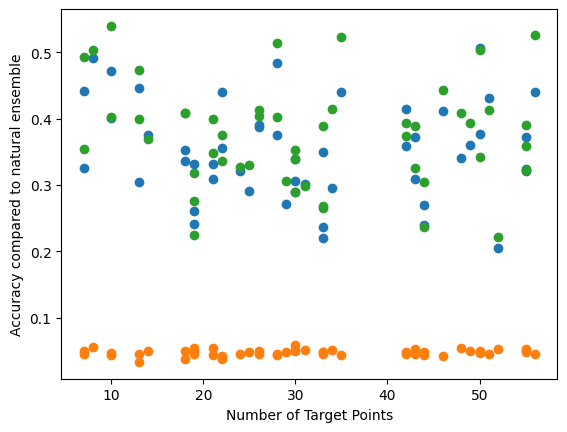

In [62]:
import matplotlib.pyplot as plt
plt.scatter(num_target_points, accuracies)
plt.scatter(num_target_points, null_accuracies)
plt.scatter(num_target_points, consensus_guesser)

plt.xlabel('Number of Target Points')
plt.ylabel('Accuracy compared to natural ensemble')